In [182]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [183]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [184]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func 
from sqlalchemy import inspect 

In [185]:
# create engine and inspector to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
insp = inspect(engine)

# list the tables 
print(insp.get_table_names())

['measurement', 'station']


In [187]:
m_cols = insp.get_columns('station')
for col in m_cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [190]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement 
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [191]:
# Find the most recent date in the data set.
end_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

The data are daily rainfall totals and some kind of temperature, possibly daily max.  
I will import data from all the stations, so the date will not be able to be used as an index.

In [192]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = date(*map(int, end_date_str[0].split('-')))

# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)
print(f"start date = {start_date}, end date = {end_date}")

# Perform a query to retrieve the data and precipitation scores
start_date_str = start_date.strftime("%Y-%m-%d")
precip_df = pd.DataFrame(session.query(Measurement.date, Measurement.station, Measurement.prcp).filter(Measurement.date > start_date_str).all())

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date (and station number)  
precip_df = precip_df.sort_values(by=['date', 'station'])  

#convert the date string into datetime 
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df.info()

start date = 2016-08-23, end date = 2017-08-23
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 360 to 1523
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     2223 non-null   datetime64[ns]
 1   station  2223 non-null   object        
 2   prcp     2015 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 69.5+ KB


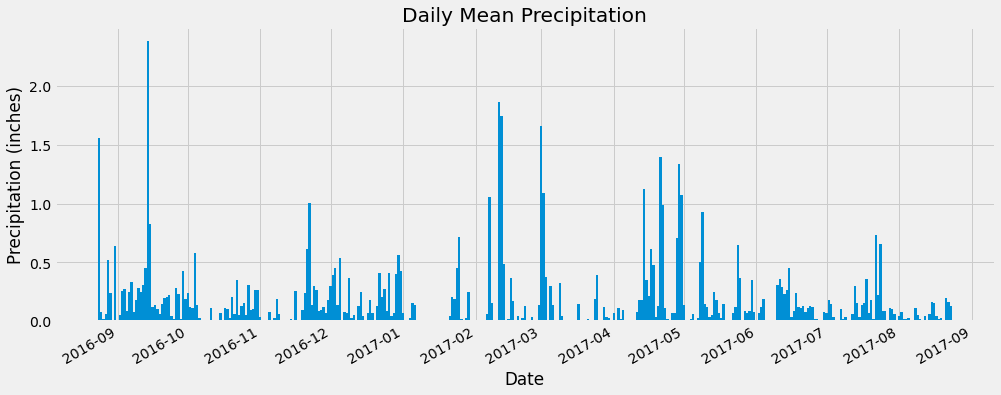

In [193]:
# Use Pandas Plotting with Matplotlib to plot the data
# I will plot out the mean from all the stations as a time series 
mean_precip = precip_df[['date','prcp']].groupby(by='date').mean()

fig,ax = plt.subplots(figsize=(15,6))
ax.bar(mean_precip.index,mean_precip['prcp'],width=1.0)
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Daily Mean Precipitation")

# Major ticks every month.
fmt_month = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(fmt_month)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate() 
plt.show()

In [194]:
# Use Pandas to calcualte the summary statistics for the precipitation data
cols = ['count', 'mean','std', 'min', '25%', '50%', '75%', 'max']
station_list = precip_df['station'].unique()
station_summary_df = pd.DataFrame(columns=cols, index=station_list)

for station in station_list:
    results = precip_df.loc[precip_df['station'] == station].describe()
    station_summary_df.loc[station] = results['prcp']

station_summary_df = station_summary_df.sort_values(by='count', ascending=False)
station_summary_df    

,count,mean,std,min,25%,50%,75%,max
USC00519397,358.0,0.044944,0.189059,0.0,0.0,0.0,0.02,2.62
USC00519281,351.0,0.194416,0.41105,0.0,0.0,0.06,0.185,2.98
USC00513117,342.0,0.141404,0.341744,0.0,0.0,0.03,0.1175,2.9
USC00516128,327.0,0.449878,0.71814,0.0,0.01,0.18,0.605,6.7
USC00519523,313.0,0.121374,0.509785,0.0,0.0,0.0,0.06,6.25
USC00514830,264.0,0.12572,0.316856,0.0,0.0,0.02,0.12,2.39
USC00517948,60.0,0.0765,0.317857,0.0,0.0,0.0,0.025,2.4


# Exploratory Station Analysis

In [198]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(Station.id).count()
number_stations

9

In [206]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
number_days = session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()
number_days


[('USC00518838', 342),
 ('USC00517948', 683),
 ('USC00511918', 1932),
 ('USC00514830', 1937),
 ('USC00516128', 2484),
 ('USC00519523', 2572),
 ('USC00519397', 2685),
 ('USC00513117', 2696),
 ('USC00519281', 2772)]

In [122]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [123]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [124]:
# Close Session
session.close()